In [108]:

#%matplotlib inline 

###########
#PDF PROCESSING FOR various INPUT 
# DEPENDING ON THE PDF_PROCESSING CLASS
#by Carl Schleussner, Climate Analytics
#carl.schleussner@climateanalytics.org
###########
# IMPORT AND CONFIG 
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
sys.path.append("./src/")
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
from netCDF4 import Dataset,netcdftime,num2date

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

from matplotlib import rc
rc('text', usetex=True)

os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Settings
###########

# PDF Method (currently defined: hist, python_silverman)
pdf_method='python_silverman'

# Set range for years for bootstrap sampling 
bs_range=[1958,2010]

# Variablelist
varinlist=[
    'TXx',
    'TNn',
    'WSDI',
    'RX5',
    'RX1'
          ] 

ref_period=[1960,1979]
target_periods=[[1991,2010],ref_period]
period_names=['Recent','ref']

timeaxis=np.arange(1958,2011)

# Input datasets
datasets=['HadEX2','GHCNDEX','ERA','20CR','ERA_regrid','20CR_regrid']

# Set plottint colours
colordict={
    datasets[0]:"#247a9c",
    datasets[1]:"#df1a20",
    datasets[2]:"#49bc2f",
    datasets[3]:"#66087c",
    datasets[4]:"#9dbd1d",
    datasets[5]:"#c268d8"}


varoutdict={
    datasets[0]:{},    
    datasets[1]:{},    
    datasets[2]:{},    
    datasets[3]:{},    
    datasets[4]:{},    
    datasets[5]:{}}


In [109]:
##############
# HadEx2 & GHCND
##############

for varin in varinlist:
    if varin=='TXx':varin_name='TXX'
    if varin=='TNn':varin_name='TNN'
    if varin=='WSDI':varin_name='WSDI'
    if varin=='RX5':varin_name='Rx5day'
    if varin=='RX1':varin_name='Rx1day'
    for dataset in ['HadEX2','GHCNDEX']:
        print varin,dataset
        if dataset =='HadEX2':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin_name+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']
        elif dataset =='GHCNDEX':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/GHCND/GHCND_'+varin_name+'_1951-2016_RegularGrid_global_2.5x2.5deg_LSmask.nc')['Ann']
            # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
        input_data=da.DimArray(read_in_data[19580101:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )
        
        if dataset =='HadEX2':
            # mask GRL
            landmask=input_data.ix[10,:,:].copy()
            landmask[:,:]=1
            GRL_mask=Dataset('support/GRL_73x96_lat_weighted.nc4').variables['GRL'][:,:]
            landmask[np.isfinite(GRL_mask)]=0 
        if dataset == 'GHCNDEX':
            # mask GRL
            landmask=input_data.ix[10,:,:].copy()
            landmask[:,:]=1
            GRL_mask=Dataset('support/GRL_73x144_lat_weighted.nc4').variables['GRL'][:,:]
            landmask[np.isfinite(GRL_mask)]=0 
            
        # Mask for data availability (individual for each dataset)
        varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
        varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask)


TXx HadEX2
TXx GHCNDEX
TNn HadEX2
TNn GHCNDEX
WSDI HadEX2
WSDI GHCNDEX
RX5 HadEX2
RX5 GHCNDEX
RX1 HadEX2
RX1 GHCNDEX


In [110]:
##############################
# 20CR
###############
dataset='20CR'
for varin in ['TXx','TNn']:  
    print varin.lower()
  
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/*/'+varin.lower()+'*2014.nc')[0]
    nc_in=Dataset(in_file,"r")
    print varin,in_file
    # handle time information
    try:
        time=nc_in.variables['time'][:]
        datevar = []
        # if no specification
        time_unit=nc_in.variables['time'].units
        try:	
            cal_temps = nc_in.variables['time'].calendar
            datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
        except:
            datevar.append(num2date(time,units = time_unit))
        year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    except: pass

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]

    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<2010))[0]
    var_in=nc_in.variables['air'][:,:,:]
    if var_in.mean()>150:var_in-=273.15
    
    input_data=da.DimArray(var_in[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )
   
    # load landmask
    landmask=Dataset('support/94x192_landmask.nc').variables['landmask'][:,:]
    GRL_mask=Dataset('support/GRL_94x192_lat_weighted.nc4').variables['GRL'][:,:]
    landmask[np.isfinite(GRL_mask)]=0
    polar_lats=np.where(lat<=-65)[0]
    landmask[polar_lats,:]=0
    landmask[landmask!=0]=1 
    
    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask)


txx
TXx /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/20CR (peter.pfleiderer@climateanalytics.org)/txx.20CR.1851-2014.nc
No of non-NAN grid cells in Mask over Ref period:  18048
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  18048
No of non-NAN grid cells in Mask over Ref period and target period  [1960, 1979]  :  18048
tnn
TNn /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/20CR (peter.pfleiderer@climateanalytics.org)/tnn.20CR.1851-2014.nc


In [111]:
##############################
# 20CR_regrid
###############
dataset='20CR_regrid'
for varin in ['TXx','TNn']:  
    print varin.lower()
   
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/*/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")    
    # handle time information
    try:
        time=nc_in.variables['time'][:]
        datevar = []
        # if no specification
        time_unit=nc_in.variables['time'].units
        try:	
            cal_temps = nc_in.variables['time'].calendar
            datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
        except:
            datevar.append(num2date(time,units = time_unit))
        year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    except: pass

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]

    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<2010))[0]
    var_in=nc_in.variables['air'][:,:,:]
    if var_in.mean()>150:var_in-=273.15
    
    input_data=da.DimArray(var_in[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )
    
    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)


txx
tnn


In [112]:
##############
# ERA40 - ERAinterim
##############
dataset='ERA'
for varin in ['TXx','TNn']:  
    print varin.lower()
    
    # ERA40
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/'+varin.lower()+'*2002.nc')[0]
    nc_in=Dataset(in_file,"r")
    
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    
    lat=nc_in.variables['latitude'][:]
    lon=nc_in.variables['longitude'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<1979))[0]
    ERA40=nc_in.variables['t2m'][:,:,:]
    if ERA40.mean()>150:ERA40-=273.15

    ERA40=da.DimArray(ERA40[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )


    # ERAinterim
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERAinterim/'+varin.lower()+'*2016.nc')[0]
    nc_in=Dataset(in_file,"r")
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])

    lat=nc_in.variables['latitude'][:]
    lon=nc_in.variables['longitude'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1979) & (year<2010))[0]
    ERAinterim=nc_in.variables['t2m'][:,:,:]
    if ERAinterim.mean()>150:ERAinterim-=273.15

    ERAinterim=da.DimArray(ERAinterim[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )    
    
    input_data=da.concatenate((ERA40.copy(), ERAinterim.copy()), axis='year')
    
    # load landmask
    landmask=Dataset('support/181x360_landmask.nc').variables['landmask'][:,:]
    GRL_mask=Dataset('support/GRL_181x360_lat_weighted.nc4').variables['GRL'][:,:]
    landmask[np.isfinite(GRL_mask)]=0
    polar_lats=np.where(lat<=-65)[0]
    landmask[polar_lats,:]=0
    landmask[landmask!=0]=1
    
    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask)



txx
No of non-NAN grid cells in Mask over Ref period:  65160
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  65160
No of non-NAN grid cells in Mask over Ref period and target period  [1960, 1979]  :  65160
tnn


In [113]:
##############
# ERA40 - ERAinterim _regrid
############## 
dataset='ERA_regrid'
for varin in ['TXx','TNn']:  
    print varin.lower()
   
    # ERA40
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERA40/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")
    
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])
    
    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1958) & (year<1979))[0]
    ERA40=nc_in.variables['t2m'][:,:,:]
    if ERA40.mean()>150:ERA40-=273.15
        
    ERA40=da.DimArray(ERA40[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )


    # ERAinterim
    in_file=glob.glob('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/ERAinterim/'+varin.lower()+'*regrid*')[0]
    nc_in=Dataset(in_file,"r")
    # handle time information
    time=nc_in.variables['time'][:]
    datevar = []
    # if no specification
    time_unit=nc_in.variables['time'].units
    try:
        cal_temps = nc_in.variables['time'].calendar
        datevar.append(num2date(time,units = time_unit,calendar = cal_temps))
    except:
        datevar.append(num2date(time,units = time_unit))
    year=np.array([int(str(date).split("-")[0])	for date in datevar[0][:]])

    lat=nc_in.variables['lat'][:]
    lon=nc_in.variables['lon'][:]
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    relevant_years=np.where((year>=1979) & (year<2010))[0]
    ERAinterim=nc_in.variables['t2m'][:,:,:]
    if ERAinterim.mean()>150:ERAinterim-=273.15

    ERAinterim=da.DimArray(ERAinterim[relevant_years,:,:].squeeze(), axes=[year[relevant_years], lat, lon],dims=['year', 'lat', 'lon'] )

    input_data=da.concatenate((ERA40, ERAinterim), axis='year')
        
    # Mask for data availability (individual for each dataset)
    varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
    varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)


txx
tnn


In [114]:
###############
# get PDFs and bootstrap
###############

cut_interval_dict={
    'TXx':[-2,3],
    'TNn':[-3,5],
    'WSDI':[-10,20],
    'RX5':[-30,45],
    'RX1':[-30,40]
          }

for varin in varinlist:
    print '\n-------------------',varin
    
    if varin=='TXx': datasets_here=['HadEX2','GHCNDEX','ERA','20CR']
    if varin!='TXx': datasets_here=['HadEX2','GHCNDEX']
        
    for dataset in datasets_here:
        print dataset
        # relative diff for precipitation indices
        if varin in ['RX5','RX1']:relative_diff=True
        if varin not in ['RX5','RX1']:relative_diff=False
        print "relative_diff=",relative_diff
            
        varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
        varoutdict[dataset][varin].derive_distributions()
            
        varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=cut_interval_dict[varin],relative_diff=relative_diff)

        # Get bootstrapping confidence intervals
        varoutdict[dataset][varin].bootstrapping(bs_range,100)   
        varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method,relative_diff=relative_diff)
        print '...........................'


------------------- TXx
HadEX2
relative_diff= False
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0


/Users/peterpfleiderer/anaconda/envs/py_masks/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................
GHCNDEX
relative_diff= False
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................
ERA
relative_diff= False
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0


KeyboardInterrupt: 

In [26]:
with open('../varoutdict_10000_new.pkl', 'wb') as output:
    pickle.dump(varoutdict, output, pickle.HIGHEST_PROTOCOL)

In [1]:
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
sys.path.append("./src/")
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
from netCDF4 import Dataset,netcdftime,num2date

#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = 8,6

from matplotlib import rc
rc('text', usetex=True)

os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Settings
###########

# PDF Method (currently defined: hist, python_silverman)
pdf_method='python_silverman'

# Set range for years for bootstrap sampling 
bs_range=[1958,2010]

# Variablelist
varinlist=[
    'TXx',
    'TNn',
    'WSDI',
    'RX5',
    'RX1'
          ] 
# Variable Titles
varintitles=[
    'Hot extremes (TXx)',
    'Cold extremes (TNn)',
    'Warm-spell duration (WSDI)',
    '5-day heavy rainfall (Rx5day)',
    'Daily heavy rainfall (Rx1day)'
          ] 


unit_dict={
    'TXx':'TXx [$^\circ$ C]',
    'TNn':'TNn [$^\circ$ C]',
    'WSDI':'WSDI [days]',
    'RX5':'RX5 [$\%$]',
    'RX1':'RX1 [$\%$]'
          }

ref_period=[1960,1979]
target_periods=[[1991,2010],ref_period]
period_names=['Recent','ref']

timeaxis=np.arange(1958,2011)

# Input datasets
datasets=['HadEX2','GHCNDEX','ERA','20CR','ERA_regrid','20CR_regrid']

# Set plottint colours
colordict={
    datasets[0]:"#247a9c",
    datasets[1]:"#df1a20",
    datasets[2]:"#49bc2f",
    datasets[3]:"#fb9b32",
    datasets[4]:"#49bc2f",
    datasets[5]:"#fb9b32"}


varoutdict={
    datasets[0]:{},    
    datasets[1]:{},    
    datasets[2]:{},    
    datasets[3]:{},    
    datasets[4]:{},    
    datasets[5]:{}}


cut_interval_dict={
    'TXx':[-2,3],
    'TNn':[-3,5],
    'WSDI':[-10,20],
    'RX5':[-30,45],
    'RX1':[-30,40]
          }

with open('../varoutdict_10000.pkl', 'rb') as input:
    varoutdict = pickle.load(input)
    
with open('../varoutdict_10000_obs_0.8.pkl', 'rb') as input:
    varoutdict_obs = pickle.load(input)


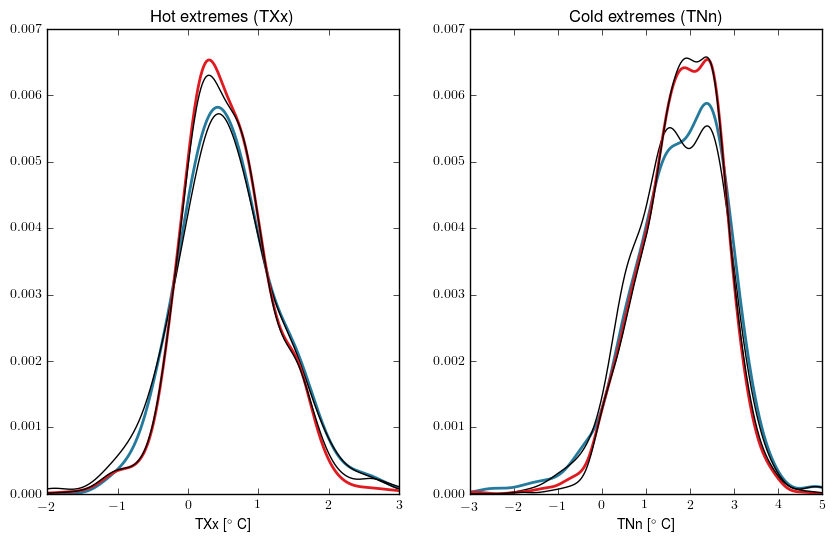

In [2]:
###########
f,pl=plt.subplots(nrows=1,ncols=2,figsize=(10,6))
pplot=pl.flatten()

region='global'
distro='pdf'

for varin,k in zip(['TXx','TNn'],[0,1]):      
    for dataset in ['HadEX2','GHCNDEX']:
        #pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]
        #pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]
        #pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
        #                    pl95,pl5,color=colordict[dataset],
        #                          alpha=0.25)
        #pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
        #              pl95,
        #              color=colordict[dataset],
        #              linewidth=1)
        #pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
        #              pl5,
        #              color=colordict[dataset],
        #              linewidth=1)  
        
        pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                      varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],
                      label=dataset,
                      color=colordict[dataset],
                      linewidth=2)
        
        pplot[k].plot(varoutdict_obs[dataset][varin]._distributions[region][distro]['xaxis'],
                      varoutdict_obs[dataset][varin]._distributions[region][distro]['Recent_ref'],
                      label=dataset,
                      color='black',
                      linewidth=1)
            
        pplot[k].set_title(varintitles[k])
        pplot[k].set_xlabel(unit_dict[varin])

plt.show()
plt.clf()

In [4]:
###########
# merge vardicts
###########


#print varoutdict['HadEX2']['TXx']._distributions['global']['pdf']['Recent_ref']    
#print varoutdict_obs['HadEX2']['TXx']._distributions['global']['pdf']['Recent_ref']    

for varin in varinlist:
    for dataset in ['HadEX2','GHCNDEX']:
        varoutdict[dataset][varin]=varoutdict_obs[dataset][varin]

In [5]:
###########
# Print output CDFs
###########

land_area_levels=[0.5,0.67,0.75]

for varin in varinlist:
    if varin=='TXx': datasets_toplot=['HadEX2','GHCNDEX','ERA','20CR']
    if varin!='TXx': datasets_toplot=['HadEX2','GHCNDEX']
    for dataset in datasets_toplot:
        y=varoutdict[dataset][varin]._distributions['global']['cdf']['Recent_ref']
        x=varoutdict[dataset][varin]._distributions['global']['cdf']['xaxis']
        print '############ '+dataset+' '+varin+' ############' 
        for la in land_area_levels:
            print la,' ', np.round(x[y>=la][0],2)

############ HadEX2 TXx ############
0.5   0.53
0.67   0.85
0.75   1.03
############ GHCNDEX TXx ############
0.5   0.52
0.67   0.83
0.75   0.98
############ ERA TXx ############
0.5   0.63
0.67   1.02
0.75   1.24
############ 20CR TXx ############
0.5   0.53
0.67   0.79
0.75   0.95
############ HadEX2 TNn ############
0.5   1.77
0.67   2.28
0.75   2.51
############ GHCNDEX TNn ############
0.5   1.92
0.67   2.32
0.75   2.51
############ HadEX2 WSDI ############
0.5   5.91
0.67   7.5
0.75   8.32
############ GHCNDEX WSDI ############
0.5   6.61
0.67   8.14
0.75   8.96
############ HadEX2 RX5 ############
0.5   2.0
0.67   6.99
0.75   9.63
############ GHCNDEX RX5 ############
0.5   2.73
0.67   7.13
0.75   9.33
############ HadEX2 RX1 ############
0.5   2.19
0.67   6.85
0.75   9.32
############ GHCNDEX RX1 ############
0.5   2.88
0.67   7.12
0.75   9.45


In [19]:
###########
# Plot Main
###########
f,pl=plt.subplots(nrows=2,ncols=3,figsize=(10,6))
pplot=pl.flatten()

region='global'
distro='pdf'

for varin,k in zip(varinlist,range(len(pplot))):
    
    #for dataset in varoutdict.keys():
    if varin=='TXx': datasets_toplot=['HadEX2','GHCNDEX','ERA','20CR']
    if varin!='TXx': datasets_toplot=['HadEX2','GHCNDEX']
        
    for dataset in datasets_toplot:
        pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]
        pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]
        pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                            pl95,pl5,color=colordict[dataset],
                                  alpha=0.25)
        
        pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                      varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],
                      label=dataset,
                      color=colordict[dataset],
                      linewidth=2)
            
        pplot[k].set_title(varintitles[k])
        pplot[k].set_xlabel(unit_dict[varin])


            
pplot[5].axis('off')
for dataset in ['HadEX2','GHCNDEX','ERA','20CR']:pplot[5].plot(1,1,label=dataset,color=colordict[dataset])
pplot[5].legend(loc='upper right')

plt.tight_layout()

#plt.savefig('../plots/Observed_0p5_degree_difference_all_DS_'+pdf_method+'_v2.pdf')
plt.savefig('../plots/Observed_0p5_degree_difference_all_DS_'+pdf_method+'_v2.png',dpi=300)
plt.clf()

In [20]:
############
# Plot Diff Maps
############

# TXX
varin='TXx'
fig,pl=plt.subplots(nrows=4,ncols=1,figsize=(6,10))
pplot=pl.flatten()
for dataset,k in zip(datasets,range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.coolwarm,
                                            color_range=[-2,2],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.25,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.1,0.6,0.8])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=unit_dict[varin])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('../plots/'+varin+'_diff_map.png',dpi=300)
plt.clf()

In [21]:
# TNN
varin='TNn'
fig,pl=plt.subplots(nrows=2,ncols=1,figsize=(6,5))
pplot=pl.flatten()
for dataset,k in zip(['HadEX2','GHCNDEX'],range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.coolwarm,
                                            color_range=[-5,5],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.25,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.1,0.6,0.8])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=unit_dict[varin])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('../plots/'+varin+'_diff_map.png',dpi=300)
plt.clf()


In [22]:
# WSDI
varin='WSDI'
fig,pl=plt.subplots(nrows=2,ncols=1,figsize=(5.5,5))
pplot=pl.flatten()
for dataset,k in zip(['HadEX2','GHCNDEX'],range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.hot_r,
                                            color_range=[0,12],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.25,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.1,0.6,0.8])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=unit_dict[varin])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('../plots/'+varin+'_diff_map.png',dpi=300)
plt.clf()

In [25]:
# RX5
varin='RX5'
fig,pl=plt.subplots(nrows=2,ncols=1,figsize=(5.5,5))
pplot=pl.flatten()
for dataset,k in zip(['HadEX2','GHCNDEX'],range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=diff=(np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask)/np.array(tmp._data_sliced['ref'])*mask*100            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.PiYG_r,
                                            color_range=[-15,15],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.25,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.1,0.6,0.8])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=unit_dict[varin])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('../plots/'+varin+'_diff_map.png',dpi=300)
plt.clf()

In [26]:
# RX1
varin='RX1'
fig,pl=plt.subplots(nrows=2,ncols=1,figsize=(5.5,5))
pplot=pl.flatten()
for dataset,k in zip(['HadEX2','GHCNDEX'],range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=diff=(np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask)/np.array(tmp._data_sliced['ref'])*mask*100            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.PiYG_r,
                                            color_range=[-15,15],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.25,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.1,0.6,0.8])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=unit_dict[varin])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('../plots/'+varin+'_diff_map.png',dpi=300)
plt.clf()

In [12]:
###########
# Plot Masks
###########
fig,pl=plt.subplots(nrows=5,ncols=2,figsize=(8,11.5))
pplot=pl.flatten()
k=0
for varin in varinlist:
    for dataset in ['HadEX2','GHCNDEX']:
        mask=varoutdict[dataset][varin]._masks['global'].copy()
        mask[np.isfinite(mask)]=1
        varoutdict[dataset][varin].plot_map(mask,
                                            ax=pplot[k],
                                            color_bar=False,
                                            show=False)
        if k<2:pplot[k].set_title(dataset)
        if (-1)**k>0:pplot[k].set_ylabel(varin)
        k+=1

plt.tight_layout()
plt.savefig('../plots/mask_HadEX2_GHCNDEX.png')
plt.savefig('../plots/mask_HadEX2_GHCNDEX.pdf')
plt.clf()

In [13]:
################
# with HadEx2 mask for ERA and 20CR
################

for varin in ['TXx']:
    for dataset in ['ERA_regrid','20CR_regrid']:
        print dataset
        
        # use HadEx2 mask
        varoutdict[dataset][varin]._masks['global']=varoutdict['HadEX2'][varin]._masks['global']
        
        # Derive time slices
        varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
        varoutdict[dataset][varin].derive_distributions()

        varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=cut_interval_dict[varin])

        # Get bootstrapping confidence intervals
        varoutdict[dataset][varin].bootstrapping(bs_range,100)   
        varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method)

ERA_regrid
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
20CR_regrid
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0


In [15]:
with open('../varoutdict_10000_regrid_combined.pkl', 'wb') as output:
    pickle.dump(varoutdict, output, pickle.HIGHEST_PROTOCOL)

In [16]:
###########
# PLOTS with reanalysis masked for HadEx2 coverage
###########
for varin in ['TXx']:
    f,pl=plt.subplots(nrows=1,figsize=(4,4))

    for dataset in ['HadEX2','GHCNDEX','ERA_regrid','20CR_regrid']:

        pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
        pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]#/varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][50].max()
        pl.fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                        pl95,pl5,color=colordict[dataset],
                              alpha=0.25),#label='90% ref period')
    
        pl.plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                 varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],
                label=dataset.replace('_',' '),color=colordict[dataset],
               linewidth=2)

        pl.legend(loc='upper right')
        pl.set_xlabel(unit_dict[varin])
        #pl.set_title(varin)


    plt.savefig('../plots/Observed_0p5_degree_difference_all_DS_'+pdf_method+'_'+varin+'_regrid_v2.pdf')
    plt.savefig('../plots/Observed_0p5_degree_difference_all_DS_'+pdf_method+'_'+varin+'_regrid_v2.png')
    plt.clf()